## COVID19 in DK

A simple SIR model fitted to COVID19 cases in Denmark. This is written mostly for my own curiosity.

In [9]:
library(deSolve)
library(ggplot2)
library(rstan)
options(mc.cores = parallel::detectCores())
rstan_options(auto_write= TRUE)

Initial conditions.

In [10]:
Ninit = 5.8e6          # Total population
Iinit = 500            # initial fraction infected
Sinit = Ninit - Iinit  # initial fraction susceptible
Rinit = 0              # no one recovered 

Initial guess for the parameters. It is assumed that $1/\gamma$ corresponds to the average number of days to recover from COVID19. $\beta$ is the rate of infection transmission. 

In [11]:
beta = 1.0/7.0
gamma = 0.06
print(beta)
print(gamma)

[1] 0.1428571
[1] 0.06


$R_0$ is the reproduction number. 

In [12]:
R0factor= beta/gamma
print(R0factor)

[1] 2.380952


Data structures.

Time intervals defined in days. Integration is done over one year. 

In [13]:
theta <- list(beta = beta,
              gamma = gamma)
inits <- c(Sinit, Iinit, Rinit)

In [14]:
t_min = 0
t_max = 365
times = t_min:t_max

The SIR model (Suceptible, Infected and Recovered) is given as
\begin{eqnarray}
    &\frac {dS} {dt} = - \beta \cdot S\cdot \frac {I} {N}\\
    &\frac {dI} {dt} =  \beta \cdot S\cdot \frac {I} {N} - \gamma \cdot I\\
    &\frac {dR} {dt} = \gamma \cdot I
\end{eqnarray}
where $N= S+I+R$

Plot of the solution.

In [15]:
SIR <- function(t, y, theta) {
    with(as.list(c(theta, y)), {
        S = y[1]
        I = y[2]
        R = y[3]
        N = S+I+R
    
        dS = - beta * S/N * I
        dI = beta * S/N * I - gamma * I
        dR = gamma * I
    
        res <- c(dS,dI,dR)
        list(res)
    })
}
out <- ode(inits, times, SIR, theta, method="ode45")
out <- data.frame(out)
colnames(out) <- c("time", "S", "I", "R")

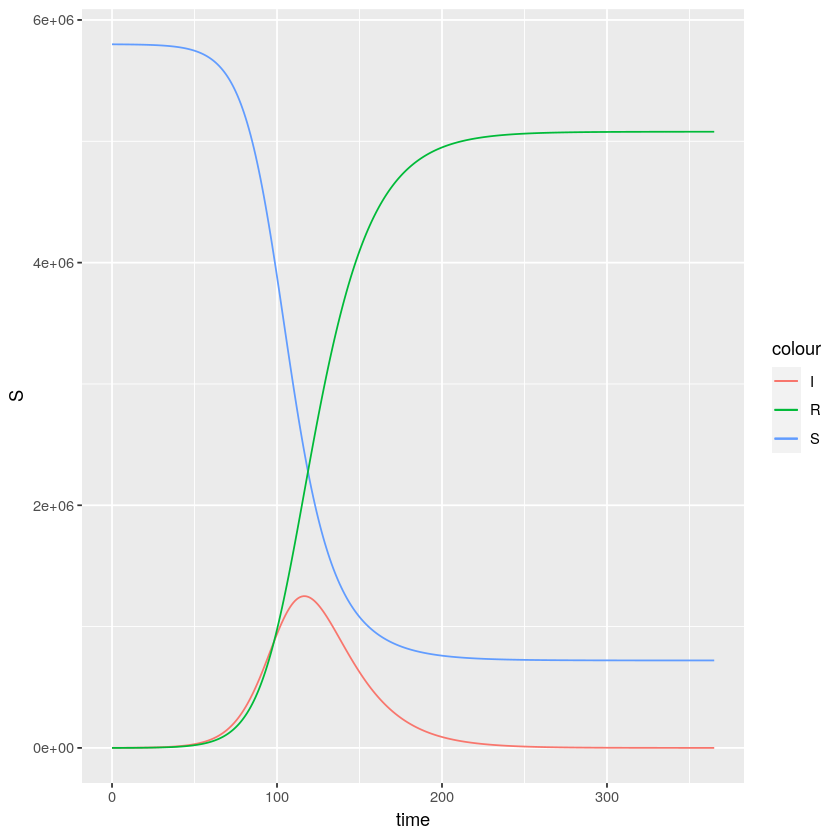

In [16]:
# quick plot of the epidemic
ggplot(out, aes(time)) +
    geom_line(aes(y = S, colour = "S"))+
    geom_line(aes(y = I, colour = "I"))+
    geom_line(aes(y = R, colour = "R"))

Here herd imunity is reached after approximately 120 days.

## Estimating infection transmission
The $\beta$ parameter controlling the spread of infection can be estimated by assuming a number of contacts and a transmission probability. 
Assume that every person meets 30 people pr day, and the probability of transmitting infection is 

In [17]:
print(beta/30,1)

[1] 0.005


This corresponds to the $R_0=2.44$, which was the reproduction number in the initial phase of the COVID19 epidemic. 

Lets assume that weak measures are imposed and the transmission probability is reduced to $1/300$. This could be due to social distancing and due to improved cleaning and hygine. Still, the number of people incounters are kept equal. This gives a new transmission coefficient $\beta_2$

In [18]:
beta2 = 30/300
R_0 = beta2/gamma
print(beta2)
print(gamma)
print(R_0)

[1] 0.1
[1] 0.06
[1] 1.666667


The new parameters are introduced into the model. 

In [19]:
theta <- list(beta = beta2,
              gamma = gamma)
inits <- c(Sinit, Iinit, Rinit)
t_min = 0
t_max = 360
times = t_min:t_max
SIR <- function(t, y, theta) {
    with(as.list(c(theta, y)), {
        S = y[1]
        I = y[2]
        R = y[3]
        N = S+I+R
    
        dS = - beta * S/N * I
        dI = beta * S/N * I - gamma * I
        dR = gamma * I
    
        res <- c(dS,dI,dR)
        list(res)
    })
}
out2 <- ode(inits, times, SIR, theta, method="ode45")
out2 <- data.frame(out2)
colnames(out2) <- c("time", "S", "I", "R")

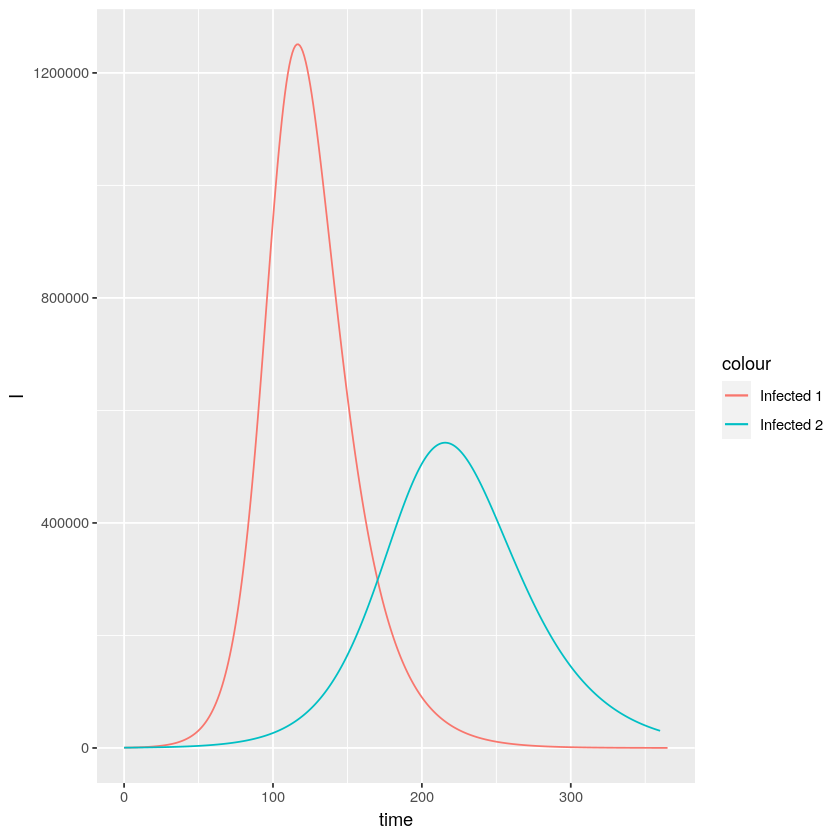

In [20]:
## Still learning to ggplot.
ggplot(NULL, aes(time, I)) + 
    geom_line(data = out, aes(colour="Infected 1")) +
    geom_line(data = out2, aes(colour="Infected 2"))

The lockdown in Denmark has reduced the number of encounters between people; lets assumed 8 people per day. Furthermore, the requirement for 2m distancing and increased hygine has reduced the transmission probability; lets assume $1/200$. Then, the parameters of the model are given as: 

In [21]:
beta3 = 8/200
R_0 = beta3/gamma
print(R_0)

[1] 0.6666667


It is seen that the estimate for $R_0$ is close to the current estimate of 0.7. The evolution of infections is illustrated below. The initial conditions are changed to show the effect of lockdown after a number of persons have been infected.

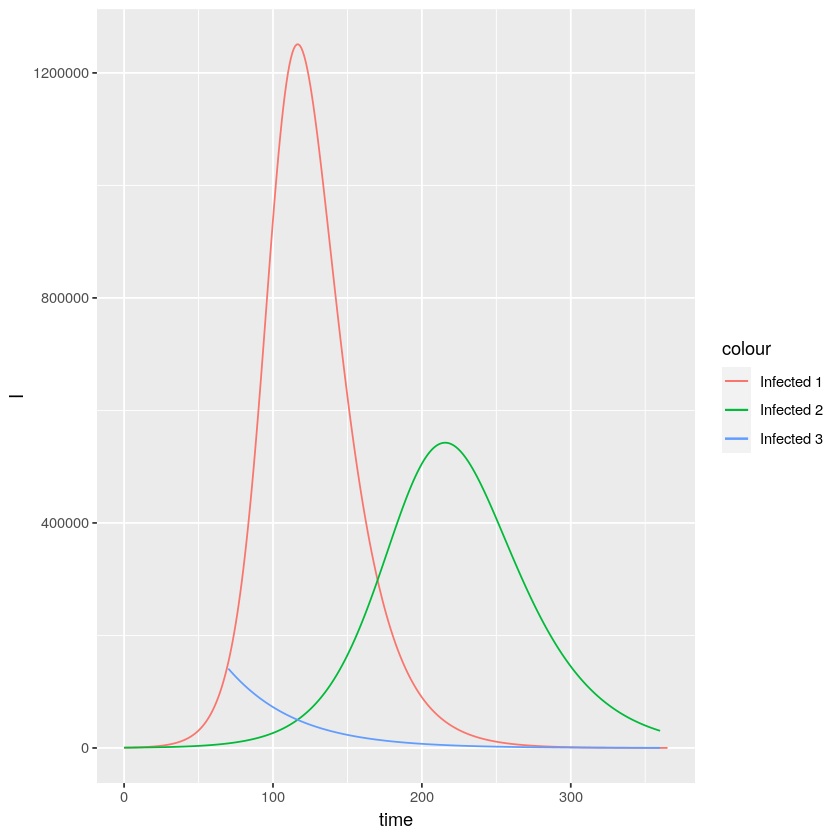

In [22]:
starttime3 = 70
Ninit = 5.8e6          # Total population
Iinit = out$I[starttime3]      # initial fraction infected
Sinit = Ninit - Iinit  # initial fraction susceptible
Rinit = out$R[starttime3]      # no one recovered
theta <- list(beta = beta3,
              gamma = gamma)
inits <- c(Sinit, Iinit, Rinit)
t_min = starttime3
t_max = 360
times = t_min:t_max
SIR <- function(t, y, theta) {
    with(as.list(c(theta, y)), {
        S = y[1]
        I = y[2]
        R = y[3]
        N = S+I+R
    
        dS = - beta * S/N * I
        dI = beta * S/N * I - gamma * I
        dR = gamma * I
    
        res <- c(dS,dI,dR)
        list(res)
    })
}
out3 <- ode(inits, times, SIR, theta, method="ode45")
out3 <- data.frame(out3)
colnames(out3) <- c("time", "S", "I", "R")

ggplot(NULL, aes(time, I)) + 
    geom_line(data = out, aes(colour="Infected 1")) +
    geom_line(data = out2, aes(colour="Infected 2"))+
    geom_line(data = out3, aes(colour="Infected 3"))

## DOTS
These estimtes follow the DOTS principle. 

- R0 can be quantitatively described as a product of D x O x T x S
- D = duration (number of days someone is infectious)
- O = opportunities for transmission (number of person-person greetings / day)
- T = probability of transmission
- S = susceptibility (proportion of population susceptible)

This has been elaborated (here)[https://www.tibco.com/blog/2020/03/18/covid-19-a-visual-data-science-analysis-and-review/]

# Data fit
Fit data from SSI using STAN

First import data.

In [23]:
dataDK <- read.csv2(file = 'data-2020-05-06/Test_pos_over_time.csv')
dataDK$Dato <- as.Date(dataDK$Dato,"%d. %B")
dataDK$Dag <- as.numeric(row.names(dataDK))
dataDK$Accumuleret_COVID<- cumsum(dataDK$Antal_COVID)

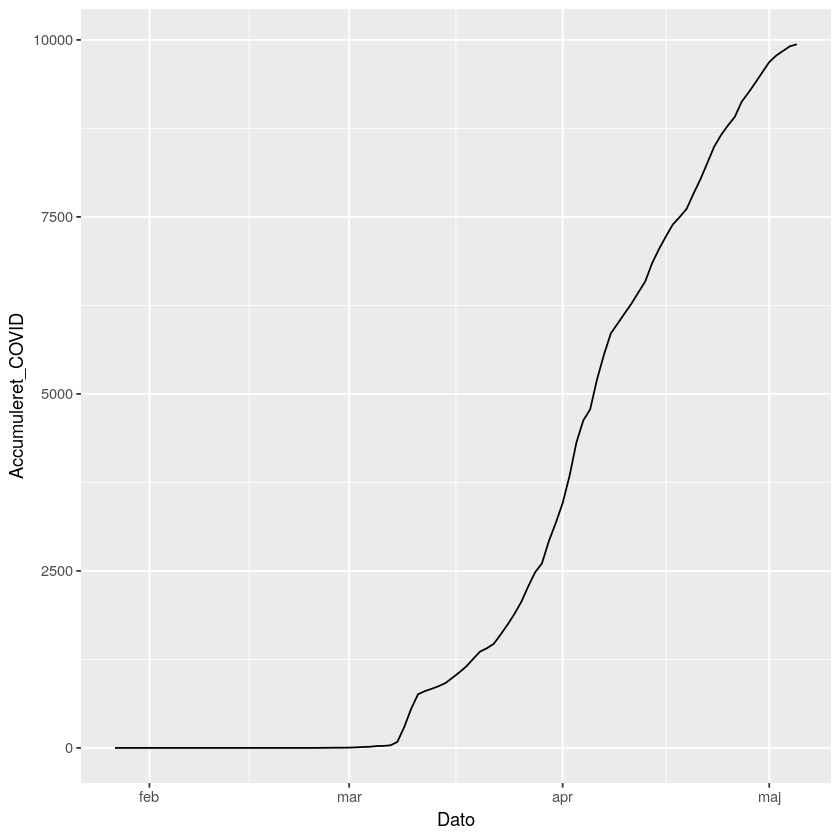

In [24]:
ggplot(dataDK, aes(Dato,Accumuleret_COVID)) +
  geom_line()

In [25]:
modelSIR <- stan_model("model_sir2.stan")

In [26]:
dataDK$Dato[40:50]
dataDK$Accumuleret_COVID[40:50]
dataDK$Dag[40:50]
length(dataDK$Dag[40:50] )

[1] "2020-03-06" "2020-03-07" "2020-03-08" "2020-03-09" "2020-03-10"
 [6] "2020-03-11" "2020-03-12" "2020-03-13" "2020-03-14" "2020-03-15"
[11] "2020-03-16"

[1]  28  37  85 295 551 758 802 835 872 917 991

[1] 40 41 42 43 44 45 46 47 48 49 50

[1] 11

In [27]:
dataSIR <- list(N = length(dataDK$Dag[40:50]), ts  = dataDK$Dag[40:50],
                N_predict=365, ts_predict = c(1:365),
                y_init = c(5.8e6,dataDK$Accumuleret_COVID[40],0), y = dataDK$Accumuleret_COVID[40:50])

In [29]:
fitSIR <- sampling(modelSIR, dataSIR, iter=1000, chains=4,
                   control=list(adapt_delta = 0.9, max_treedepth=15))

In [30]:
save(fitSIR,file="fitSIR_simulation1.dat")

In [31]:
load(file="fitSIR_simulation.dat")

ci_level: 0.8 (80% intervals)

outer_level: 0.95 (95% intervals)



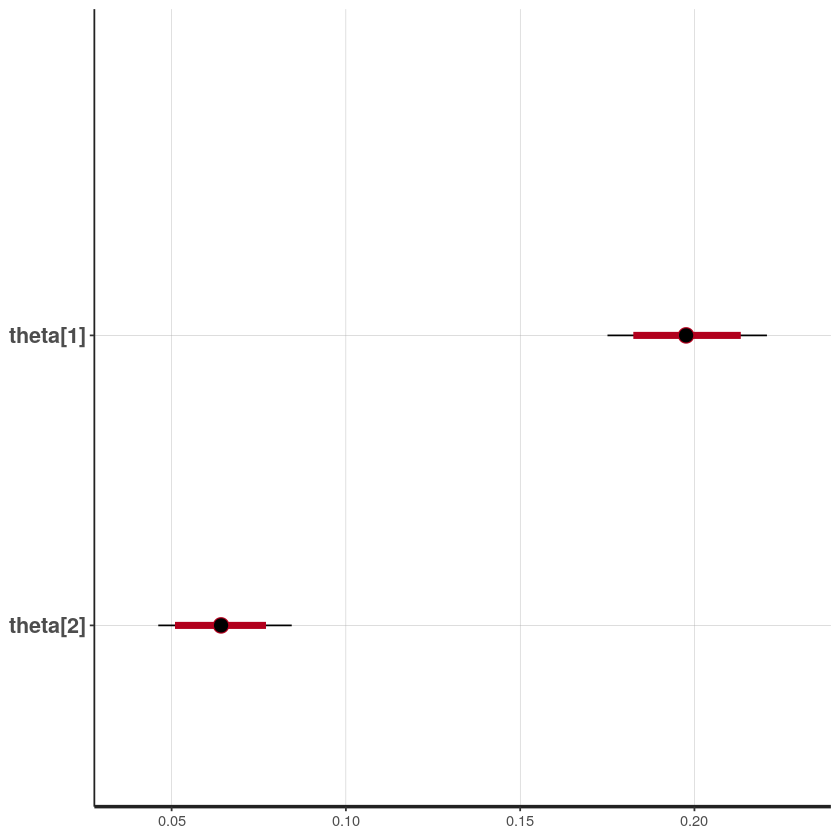

In [32]:
plot(fitSIR, pars=c("theta"))


In [33]:
posts <- extract(fitSIR)
beta_estimate <- apply(posts$theta,2,mean)[1]
gamma_estimate <- apply(posts$theta,2,mean)[2]
R_0_estimate = beta_estimate/gamma_estimate
print(R_0_estimate,2)

[1] 3.1


The $R_0$ is found to be about 3.

# Background
The SIR model is a model of infectious diseases. It divides the population into compartments of Suceptible, Infected and Recovered people. The model assumed a well mixed population, i.e. it is assumed that every person will meet every other person in the population. The latter is the first limitation of this model. 

## Editorial note
I am really struggling with the Junyper notebook format. 